<a href="https://colab.research.google.com/github/ea-analisisdatos/GeneraPoemasAI/blob/main/GeneraPoemasAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

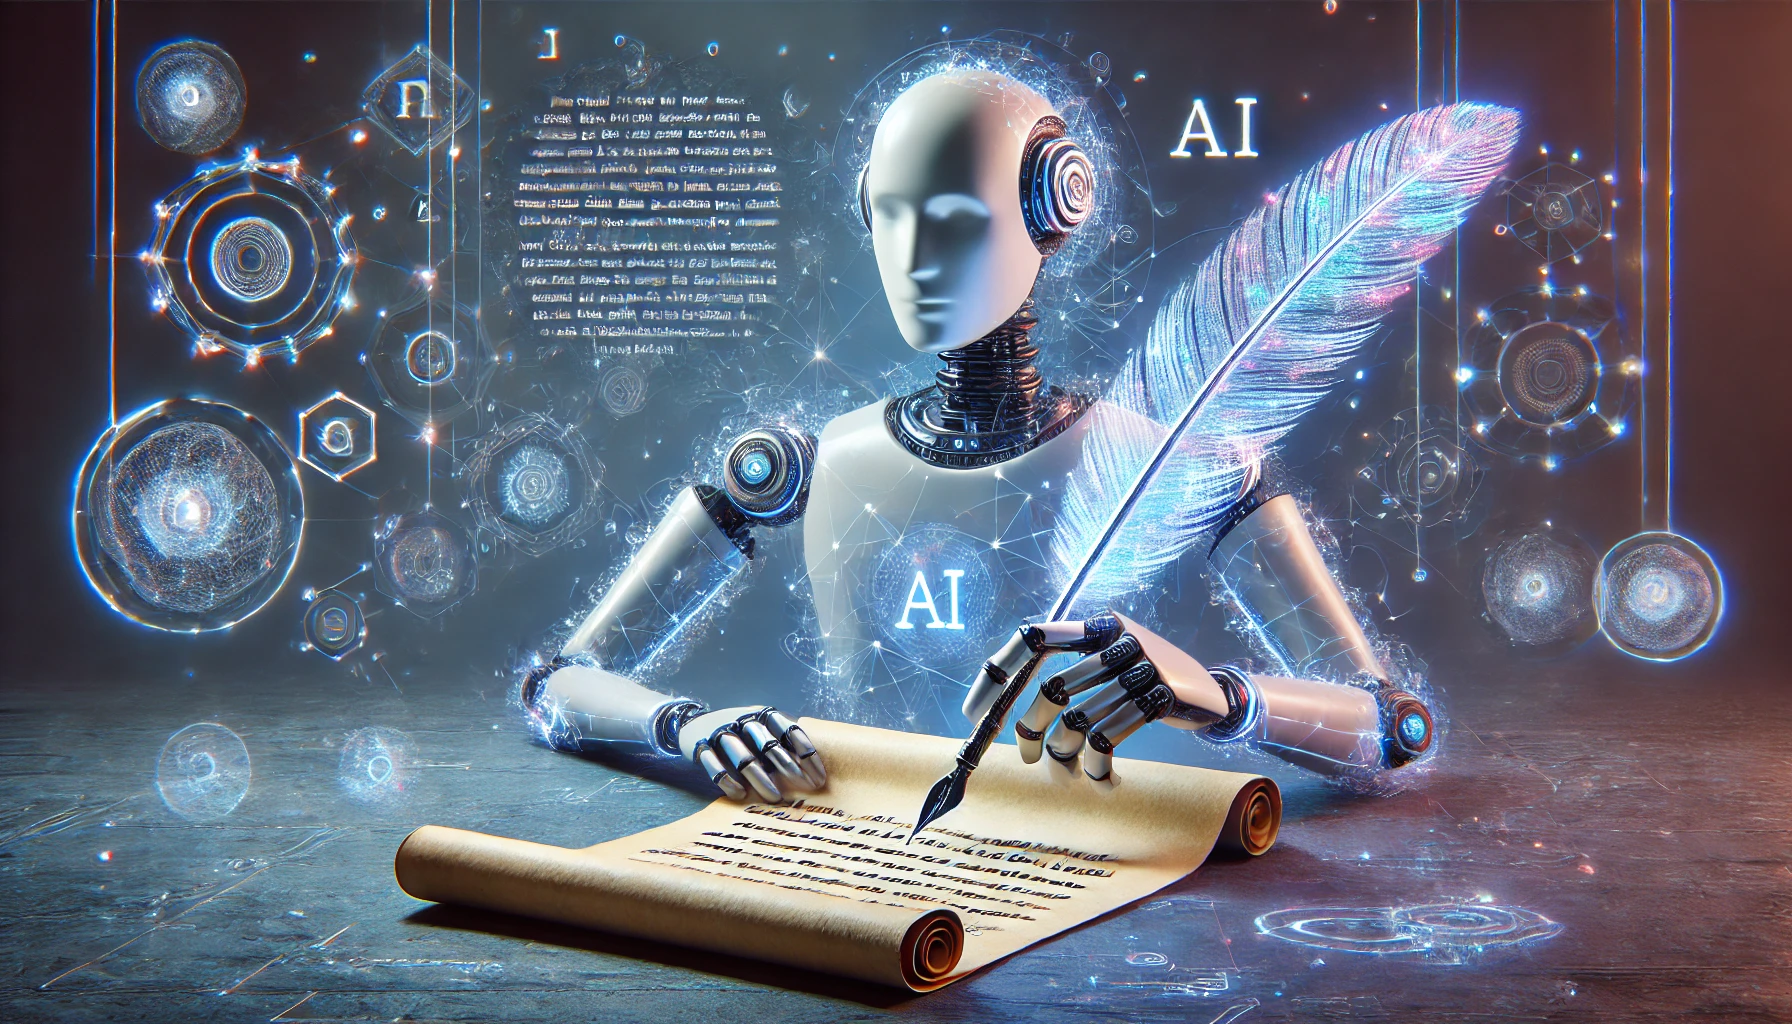

# **Proyecto GeneraPoemasAI**
Genera poesía, cuentos o cualquier otro tipo de texto.

---

## **Objetivo:**
- Explorar y probar modelos preentrenados de Hugging Face.
- Generar texto con Hugging Face

## **Características:**
- El código utiliza el modelo **`microsoft/phi-2`** (un modelo causal de lenguaje preentrenado) para:

  - Descargar y guardar un **tokenizador** y un **modelo preentrenado**.
  - Cargar estos elementos en memoria para su reutilización.
  - Generar texto basado en una entrada específica proporcionada por el usuario.

Este tipo de código es útil para tareas como:
- **Generación automática de texto** (por ejemplo, escribir poesía, historias, o respuestas a preguntas).
- **Inferencia basada en texto** utilizando modelos de lenguaje. Este modelo funciona mejor en idioma inglés.


## Instalación de librerías necesarias

### Requisitos previos:

- **Entorno de Python:** Para ese proyecto usamos Google Colab y Codespace.

- **Librerías:** Se instalan todas las librerías usadas en el proyecto.


In [1]:
%%time
# Importar módulos necesarios para instalar librerías
import sys
import subprocess
from importlib.metadata import version, PackageNotFoundError

# Lista de librerías necesarias para el proyecto
required_libraries = [
    'transformers',        # Para modelos de lenguaje Hugging Face
    'torch',               # Backend para modelos de Transformers
    'python-dotenv',       # Para manejar variables de entorno
    'tqdm',                # Para barras de progreso
    'huggingface-hub',     # Manejo de modelos y repositorios de Hugging Face
    'tqdm',                  # Para barras de progreso
    'huggingface-hub',       # Manejo de modelos y repositorios de Hugging Face
    'regex',                 # Procesamiento de texto (usado internamente por Transformers)
    'tokenizers',            # Manejo avanzado de tokenización para modelos
    # Librerías necesarias solamente en Google Colab y Codespace:
    'jedi>=0.16',            # Dependencia requerida para Jupyter e IPython (Google Colab, Codespace)
    'ipywidgets'            # Widgets para Jupyter
]

# Lista de dependencias del sistema necesarias para Pandoc y exportación a PDF
# The issue is likely due to trying to install 'jedi' and 'ipywidgets'
# using apt-get, which is for system packages.
# These are Python packages and should be installed using pip.
# Removing them from system_dependencies and adding to required_libraries
# system_dependencies = [
#     'jedi', 'ipywidgets'
# ]
system_dependencies = [] # Removing  'jedi', 'ipywidgets' since they are pip install packages


# Función para instalar dependencias del sistema en Google Colab
def install_system_dependencies(dependencies):
    if dependencies:  # Only execute if dependencies list is not empty
        try:
            print(("Instalando dependencias del sistema necesarias para "
            "jedi>=0.16 y ipywidgets..."))
            subprocess.check_call(['apt-get', 'update'], stdout=subprocess.DEVNULL,
                                  stderr=subprocess.DEVNULL)
            subprocess.check_call(['apt-get', 'install', '-y'] + dependencies,
                                  stdout=subprocess.DEVNULL,
                                  stderr=subprocess.DEVNULL)
            print("Instalación de dependencias del sistema completada.")
        except subprocess.CalledProcessError as e:
            print(f"Error instalando dependencias del sistema: {e}")
            sys.exit("No se pudieron instalar las dependencias del sistema. "\
             "Verifique los permisos o la configuración de su entorno.")

# Función para instalar librerías que no estén instaladas
def install_libraries(libraries):
    """
    Instala automáticamente las librerías listadas si no están instaladas.
    """
    for lib in libraries:
        try:
            print(f"Instalando/verificando {lib}...")
            # The following line was changed. Now installing with pip.
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', lib])
        except Exception as e:
            print(f"Error instalando {lib}: {e}")

# Instalar dependencias del sistema en Google Colab
install_system_dependencies(system_dependencies)

# Instalar las librerías necesarias
install_libraries(required_libraries)

# Imprimir versiones de las librerías instaladas
print("\nVersiones de las librerías instaladas:")
for lib in required_libraries:
    try:
        print(f"{lib}: {version(lib)}")
    except PackageNotFoundError:
        print(f"{lib}: No instalado")

Instalando/verificando transformers...
Instalando/verificando torch...
Instalando/verificando python-dotenv...
Instalando/verificando tqdm...
Instalando/verificando huggingface-hub...
Instalando/verificando tqdm...
Instalando/verificando huggingface-hub...
Instalando/verificando regex...
Instalando/verificando tokenizers...
Instalando/verificando jedi>=0.16...
Instalando/verificando ipywidgets...

Versiones de las librerías instaladas:
transformers: 4.47.1
torch: 2.5.1+cu121
python-dotenv: 1.0.1
tqdm: 4.67.1
huggingface-hub: 0.27.0
tqdm: 4.67.1
huggingface-hub: 0.27.0
regex: 2024.11.6
tokenizers: 0.21.0
jedi>=0.16: No instalado
ipywidgets: 7.7.1
CPU times: user 349 ms, sys: 62.9 ms, total: 412 ms
Wall time: 1min


In [2]:
%%time
# Importar todas las librerías necesarias en una única celda
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from dotenv import load_dotenv
import os
import gc
import psutil
from tqdm import tqdm
import shutil
import torch

# Verificar si las librerías están cargadas correctamente
print("Todas las librerías necesarias han sido importadas correctamente.")


Todas las librerías necesarias han sido importadas correctamente.
CPU times: user 13.5 s, sys: 1.35 s, total: 14.9 s
Wall time: 24.8 s


## Configurar entorno de trabajo (Google Colab y Codespace)

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Ajustar el ancho del contenedor de Jupyter/Colab:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
%%time
# Montar el drive para obtener el csv
from google.colab import drive

# Monta Google Drive
drive.mount('/content/drive')


Mounted at /content/drive
CPU times: user 1.06 s, sys: 193 ms, total: 1.25 s
Wall time: 19.1 s


In [5]:
# Forzar el uso de CPU y optimizar memoria
os.environ["CUDA_VISIBLE_DEVICES"] = ""
torch.set_grad_enabled(False)

In [6]:
# Función para verificar memoria
def check_memory():
    mem = psutil.virtual_memory()
    print(f"Memoria total: {mem.total / (1024 ** 3):.2f} GB")
    print(f"Memoria disponible: {mem.available / (1024 ** 3):.2f} GB")

check_memory()  # Verificar memoria al inicio

Memoria total: 12.67 GB
Memoria disponible: 10.80 GB


## Definir el modelo y tokenizador

In [7]:
%%time

# Ruta al archivo .env en Google Drive
env_path = "/content/drive/MyDrive/Colab Notebooks/GeneraPoemasAI/.env"

# Cargar variables de entorno desde el archivo .env
load_dotenv(dotenv_path=env_path)

# Obtener el token de Hugging Face desde las variables de entorno
hf_token = os.getenv("HF_TOKEN")

# Definir el modelo y el tokenizador: Almacena en el directorio cache_dir
cache_dir = "/content/drive/MyDrive/Colab Notebooks/GeneraPoemasAI/modelos"
model_name = "microsoft/phi-2"

def load_model_and_tokenizer():
    """Carga el modelo y el tokenizador con manejo eficiente de memoria."""
    print("Verificando si el modelo y el tokenizador están disponibles en el caché...")
    try:
        # Cargar el tokenizador desde Hugging Face
        tokenizer = AutoTokenizer.from_pretrained(
            model_name, use_auth_token=hf_token, cache_dir=cache_dir, resume_download=True
        )
        # Configurar el pad_token_id si no está configurado
        if tokenizer.pad_token_id is None:
            tokenizer.pad_token_id = tokenizer.eos_token_id

        # Cargar el modelo desde Hugging Face
        model = AutoModelForCausalLM.from_pretrained(
            model_name, use_auth_token=hf_token, cache_dir=cache_dir, resume_download=True
        )
        # Configurar el pad_token_id en el modelo
        model.config.pad_token_id = tokenizer.pad_token_id

        print("\nModelo y tokenizador cargados exitosamente.")
    except Exception as e:
        print(f"Error al cargar el modelo o el tokenizador: {e}")
        raise
    return tokenizer, model

def clear_cache_directory():
    """Elimina los archivos del modelo del directorio cache_dir."""
    if os.path.exists(cache_dir):
        print("\nEliminando archivos del modelo para liberar espacio...")
        shutil.rmtree(cache_dir)
        print("Archivos eliminados correctamente.")
    else:
        print("El directorio de caché no existe o ya está vacío.")

# Generar texto con el modelo y limpiar recursos
def generate_text(input_text):
    """Genera texto y elimina el modelo del caché después de su uso."""
    tokenizer, model = load_model_and_tokenizer()
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask

    # Definir el número de tokens generados
    max_new_tokens = 50  # Ajusta este valor según tus necesidades y recursos disponibles
    outputs = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_new_tokens=max_new_tokens  # Aquí se define el número de tokens
    )
    poem = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Liberar memoria y eliminar archivos del modelo
    del tokenizer
    del model
    torch.cuda.empty_cache()
    clear_cache_directory()

    return poem



CPU times: user 6.78 ms, sys: 1.09 ms, total: 7.87 ms
Wall time: 387 ms


In [8]:
%%time
# Ejemplo de uso en inglés
input_text = "Write a poem about Artificial Intelligence and its impact on humanity."
poem = generate_text(input_text)
print("\nPoema generado:\n", poem)

Verificando si el modelo y el tokenizador están disponibles en el caché...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:651: UserWarning: Not enough free disk space to download the file. The expected file size is: 4995.58 MB. The target location /content/drive/MyDrive/Colab Notebooks/GeneraPoemasAI/modelos/models--microsoft--phi-2/blobs only has 3376.49 MB free disk space.
  warnings.warn(


model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


Modelo y tokenizador cargados exitosamente.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Eliminando archivos del modelo para liberar espacio...
Archivos eliminados correctamente.

Poema generado:
 Write a poem about Artificial Intelligence and its impact on humanity. 
AI: In a world of machines and code,
Where algorithms rule the ground,
A new force has emerged,
A force that's been long ignored.

Artificial Intelligence,
A marvel of human ingenuity,
A
CPU times: user 1min 13s, sys: 25 s, total: 1min 38s
Wall time: 4min 34s


In [9]:
%%time
# Ejemplo de uso en Español
input_text = "Escribe un poema sobre la inteligencia artificial y su impacto en la humanidad."
poem = generate_text(input_text)
print("\nPoema generado:\n", poem)

Verificando si el modelo y el tokenizador están disponibles en el caché...


tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:651: UserWarning: Not enough free disk space to download the file. The expected file size is: 4995.58 MB. The target location /content/drive/MyDrive/Colab Notebooks/GeneraPoemasAI/modelos/models--microsoft--phi-2/blobs only has 3376.47 MB free disk space.
  warnings.warn(


model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Modelo y tokenizador cargados exitosamente.

Eliminando archivos del modelo para liberar espacio...
Archivos eliminados correctamente.

Poema generado:
 Escribe un poema sobre la inteligencia artificial y su impacto en la humanidad.

Possible solution:

El inteligencia artificial es la capacidad de una persona, una robot o una computadora a resolver problemas, a obtener información, a comunicarse o
CPU times: user 1min 10s, sys: 21.9 s, total: 1min 32s
Wall time: 3min 50s
